In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
import requests
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft
from scipy.signal import get_window, spectrogram
import pickle
import re
from collections import Counter
from scipy.optimize import curve_fit

In [3]:
os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/')

['LERFUJI_2024-11-23_04-59-37.npz',
 'LERFUJI_2024-11-22_11-00-49.npz',
 'LERFUJI_2024-10-27_15-59-34.npz',
 'LERFUJI_2024-10-22_06-38-26.npz',
 'LERFUJI_2024-11-21_23-51-33.npz',
 'LERFUJI_2024-10-19_01-22-42.npz',
 'LERFUJI_2024-10-30_06-56-57.npz',
 'LERFUJI_2024-10-25_07-16-13.npz',
 'LERFUJI_2024-11-12_12-19-42.npz',
 'LERFUJI_2024-10-28_21-34-21.npz',
 'LERFUJI_2024-10-17_01-05-01.npz',
 'LERFUJI_2024-11-05_16-02-11.npz',
 'LERFUJI_2024-10-29_12-25-14.npz',
 'LERFUJI_2024-11-18_11-44-54.npz',
 'LERFUJI_2024-10-22_15-14-57.npz',
 'LERFUJI_2024-10-28_22-58-10.npz',
 'LERFUJI_2024-11-08_10-06-35.npz',
 'LERFUJI_2024-10-30_00-36-22.npz',
 'LERFUJI_2024-11-15_16-14-39.npz',
 'LERFUJI_2024-10-10_22-11-36.npz',
 'LERFUJI_2024-11-11_07-56-44.npz',
 'LERFUJI_2024-10-29_21-24-26.npz',
 'LERFUJI_2024-10-22_03-20-25.npz',
 'LERFUJI_2024-10-21_22-10-13.npz',
 'LERFUJI_2024-11-08_10-19-38.npz',
 'LERFUJI_2024-11-08_14-43-51.npz',
 'LERFUJI_2024-10-15_11-30-38.npz',
 'LERFUJI_2024-10-25_03-22-5

In [3]:
def make_plot(filename1):
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/'+filename1,allow_pickle=True)
    X_sum=npz_kw['X_sum']
    X_delta=npz_kw['X_delta']
    Y_sum=npz_kw['Y_sum']
    Y_delta=npz_kw['Y_delta']
    print(len(X_sum))

    
    if filename1=="LERFUJI_2024-10-16_08-57-48.npz":
        return np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),np.array([np.nan])
    if filename1=="LERFUJI_2024-10-15_19-08-53.npz":
        return np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),np.array([np.nan])
    if filename1=="LERFUJI_2024-10-16_01-58-36.npz":
        Y_sum=np.zeros(len(Y_delta))

    timesteps2=np.arange(len(X_sum))/509
    timesteps2=timesteps2-timesteps2[-1]
    
    ##################    



    df = pd.DataFrame({'x':timesteps2,'X_sum':X_sum,'X_delta':X_delta,'Y_sum':Y_sum,'Y_delta':Y_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result_x'] = np.where(df['X_sum'] > threshold, df['X_delta'] / df['X_sum']*(16.58/5), 0)
    # 'result' から オフセットの値を引き算
    df['result_diff_x'] = df['result_x'] 
    offset = df['result_x'].iloc[0:5120].reset_index(drop=True)  # 1行目から5120行目の値
    
    for i in range(1, len(df) // 5120):
        start = i * 5120
        end = start + 5120-1
        df.loc[start:end, 'result_diff_x'] -= offset.values
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_x'] = np.where(abs(df['result_diff_x']) > 1.5, 0, df['result_diff_x'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_x'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff_x'])
    moving_avg = df['result_diff_x'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_x'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['x_moving_avg'] = moving_avg.reindex(df.index)
    df['x_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_x'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff_x'])
    df['result_interp_x']=df['result_diff_x']#.interpolate(method='spline',order=1)

    df['result_y'] = np.where(df['X_sum'] > threshold, df['Y_delta'] / df['Y_sum']*(16.58/5), 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_y'] = df['result_y']
    offset = df['result_y'].iloc[0:5120].reset_index(drop=True)  # 1行目から5120行目の値
    for i in range(1, len(df) // 5120):
        start = i * 5120
        end = start + 5120-1
        df.loc[start:end, 'result_diff_y'] -= offset.values
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_y'] = np.where(abs(df['result_diff_y']) > 1.5, 0, df['result_diff_y'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_y'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff_y'])
    moving_avg = df['result_diff_y'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_y'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['y_moving_avg'] = moving_avg.reindex(df.index)
    df['y_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_y'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff_y'])
    df['result_interp_y']=df['result_diff_y']#.interpolate(method='spline',order=1)

    # 条件に従って 'result' を計算
    df['result_charge'] = np.where(df['X_sum'] > threshold,  df['X_sum']+df['Y_sum'], np.nan)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_charge'] = df['result_charge'] / df['result_charge'].shift(51200)

    condition = df['X_sum'] <= 2000
    # 連続する2000以下の行数をカウント
    df['group'] = (condition != condition.shift()).cumsum()
    df['count'] = df.groupby('group')['X_sum'].transform('size')
    # 2000以下の連続が300行以上になる部分を削除
    index_to_drop = df[(condition) & (df['count'] >= 300)].index[0] if len(df[(condition) & (df['count'] >= 300)]) > 0 else None
    # 該当部分を削除
    if index_to_drop is not None:
        df = df[:index_to_drop]  # 連続部分の開始行以降を削除



    step_size = 40
    turn=len(df)//5120-10
    if turn<10:
        return np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),np.array([np.nan])
    tbtdata_111_x=df['result_interp_x'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_x_ma=df['x_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_x_std=df['x_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y=df['result_interp_y'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y_ma=df['y_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y_std=df['y_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    charge_111=df['result_diff_charge'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    
    #tbtdata_111=tbtdata_111.reshape(turn,5120)
    turn111=turn

    iii=90
    a=tbtdata_111_x_ma[-iii*5120:]
    b=np.full(iii*5120,np.nanstd(tbtdata_111_x))*0.6
    index_111 = next(
            (i for i, (a_val, b_val) in enumerate(zip(a, b))
             if not np.isnan(a_val) and not np.isnan(b_val) and abs(a_val) > b_val),
            iii*5120
        )
    index_111=index_111-iii*5120
    print(index_111)
    a=tbtdata_111_y_ma[-iii*5120:]
    b=np.full(iii*5120,np.nanstd(tbtdata_111_y))*0.6
    index_111_y = next(
            (i for i, (a_val, b_val) in enumerate(zip(a, b))
             if not np.isnan(a_val) and not np.isnan(b_val) and abs(a_val) > b_val),
            iii*5120
        )
    index_111_y=index_111_y-iii*5120
    print(index_111_y)

    if np.nanmax(tbtdata_111_x[:50*5120])-np.nanmin(tbtdata_111_x[:50*5120]) > 0.3:
        return np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),np.array([np.nan])

    if np.nanmax(tbtdata_111_y[:50*5120])-np.nanmin(tbtdata_111_y[:50*5120]) > 0.3:
        return np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),np.array([np.nan])
    

    return tbtdata_111_x_ma[:50*5120], tbtdata_111_y_ma[:50*5120], tbtdata_111_x_ma[-10*5120:], tbtdata_111_y_ma[-10*5120:]



In [128]:
charge=[]
for i in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/'):
    a=make_plot(i)
    charge.append(a)

524288
-58
-370662
524288
524288
0
0
524288
-455317
0
524288
0
-114873
524288
-18223
-13529
524288
-15981
-14683
524288
524288
524288
0
0
524288
524288
-71
0
524288
524288
524288
524288
524288
524288
0
0
524288
524288
0
0
524288
-23
-460633
524288
524288
-38962
-9792
524288
524288
524288
524288
-167242
-34344
524288
524288
0
0
524288
524288
-56
-457686
524288
524288
-27861
-24836
524288
0
0
524288
0
0
524288
0
0
524288
524288
-43704
-40187
524288
524288
524288
-455779
0
524288
-57901
-39919
524288
524288
524288
-58002
-27500
524288
524288
524288
-21011
-4396
524288
524288
524288
524288
-84
-458332
524288
524288
524288
-23393
-6875
524288
524288
-25129
-18067
524288
524288
-68032
-52630
524288
524288
524288
-75
-420393
524288
524288
524288
-49996
-34691
524288
524288
524288
524288
524288
-52
-443150
524288
524288
524288
524288
-4379
0
524288
-52546
-22281
524288
524288
524288
524288
524288
0
-452809
524288
0
0
524288
-52019
-46099
524288
524288
524288
524288
-25
-442528
524288
524288
-1

/tmp/ipykernel_344132/205011522.py:123: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(tbtdata_111_y[:50*5120])-np.nanmin(tbtdata_111_y[:50*5120]) > 0.2:


524288
524288
0
0
524288
524288
524288
524288
-22347
-14531
524288
524288
524288
524288
-35291
-18479
524288
-4702
-452523
524288
524288
524288
524288
524288
524288
-78890
-40556
524288
524288
524288
524288
0
0
524288
524288
0
0
524288
524288
524288
524288
524288
-55303
-47065
524288
524288
524288
524288
-284821
-20861
524288
0
-424992
524288
524288
-31863
-31030
524288
524288
524288
-258742
-260216
524288
524288
524288
524288
-17112
-17372
524288
0
0
524288
0
0
524288
-4714
-393779
524288
-44
-422553
524288
524288
524288
524288
524288
0
0
524288
524288
524288


In [132]:
x_ma=[]
y_ma=[]
x_ma_osc=[]
y_ma_osc=[]
for i in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/'):
    a,b,c,d=make_plot(i)
    x_ma.append(a)
    y_ma.append(b)
    x_ma_osc.append(c)
    y_ma_osc.append(d)
    

524288
-58
-370662
524288
524288
0
0
524288
-455317
0
524288
0
-114873
524288
-18223
-13529
524288
-15981
-14683
524288
524288
524288
0
0
524288
524288
-71
0
524288
524288
524288
524288
524288
524288
0
0
524288
524288
0
0
524288
-23
-460633
524288
524288
-38962
-9792
524288
524288
524288
524288
-167242
-34344
524288
524288
0
0
524288
524288
-56
-457686
524288
524288
-27861
-24836
524288
0
0
524288
0
0
524288
0
0
524288
524288
-43704
-40187
524288
524288
524288
-455779
0
524288
-57901
-39919
524288
524288
524288
-58002
-27500
524288
524288
524288
-21011
-4396
524288
524288
524288
524288
-84
-458332
524288
524288
524288
-23393
-6875
524288
524288
-25129
-18067
524288
524288
-68032
-52630
524288
524288
524288
-75
-420393
524288
524288
524288
-49996
-34691
524288
524288
524288
524288
524288
-52
-443150
524288
524288
524288
524288
-4379
0
524288
-52546
-22281
524288
524288
524288
524288
524288
0
-452809
524288
0
0
524288
-52019
-46099
524288
524288
524288
524288
-25
-442528
524288
524288
-1

/tmp/ipykernel_344132/1580036337.py:123: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(tbtdata_111_y[:50*5120])-np.nanmin(tbtdata_111_y[:50*5120]) > 0.3:


524288
524288
0
0
524288
524288
524288
524288
-22347
-14531
524288
524288
524288
524288
-35291
-18479
524288
-4702
-452523
524288
524288
524288
524288
524288
524288
-78890
-40556
524288
524288
524288
524288
0
0
524288
524288
0
0
524288
524288
524288
524288
524288
-55303
-47065
524288
524288
524288
524288
-284821
-20861
524288
0
-424992
524288
524288
-31863
-31030
524288
524288
524288
-258742
-260216
524288
524288
524288
524288
-17112
-17372
524288
0
0
524288
0
0
524288
-4714
-393779
524288
-44
-422553
524288
524288
524288
524288
524288
0
0
524288
524288
524288


In [18]:
x_ma

[array([       nan,        nan,        nan, ..., 0.01738832,        nan,
        0.0178269 ]),
 array([nan]),
 array([       nan,        nan,        nan, ..., 0.00510183,        nan,
        0.00562529]),
 array([        nan,         nan,         nan, ...,         nan,
                nan, -0.03851111]),
 array([       nan,        nan,        nan, ...,        nan,        nan,
        0.00648702]),
 array([        nan,         nan,         nan, ...,         nan,
                nan, -0.12726035]),
 array([        nan,         nan,         nan, ..., -0.43180596,
                nan, -0.43254608]),
 array([nan]),
 array([nan]),
 array([       nan,        nan,        nan, ..., 0.0002608 ,        nan,
        0.00074436]),
 array([nan]),
 array([       nan,        nan,        nan, ...,        nan,        nan,
        0.02696386]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([       nan,        nan,        nan, ...,        nan,        nan,
        0.0038

46848683
19493150


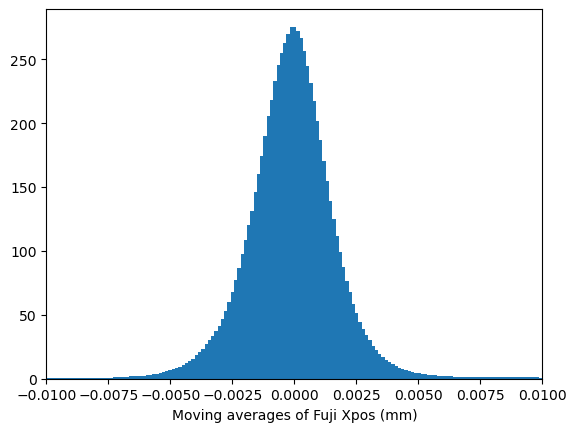

0.002007223710222131


In [138]:
a=np.concatenate(x_ma)
print(len(a))
a=a[~np.isnan(a)]
print(len(a))
a=a[(a >= -0.02) & (a < 0.02)]

b=np.concatenate(x_ma_osc)
b=b[~np.isnan(b)]


plt.hist(a,bins=300,density=True)
#plt.hist(np.abs(b),bins=5000,density=True,alpha=0.5)
plt.xlim(-0.01,0.01)
#plt.yscale('log')
plt.xlabel('Moving averages of Fuji Xpos (mm)')
plt.savefig('output.png',dpi=100)
plt.show()
"""
sorted_data = np.sort(np.abs(a))
# 2. 累積確率を計算
cumulative_prob = np.cumsum(sorted_data) / np.sum(sorted_data)
# 3. 累積確率0.99になる値を探す
threshold_index = np.where(cumulative_prob >= 0.95)[0][0]
threshold_value = sorted_data[threshold_index]
print(threshold_value)
"""
print(np.std(a))


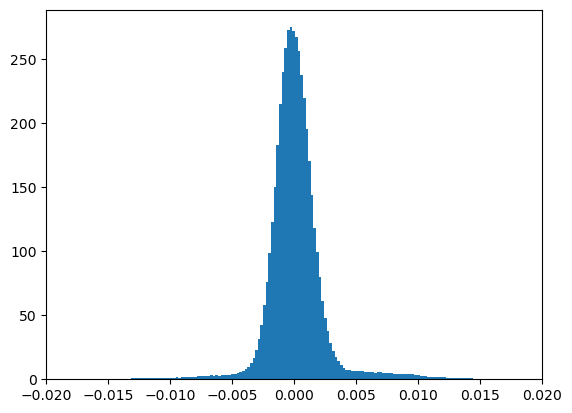

0.0024423697775640693


In [102]:
a=np.concatenate(y_ma)
a=a[~np.isnan(a)]
b=np.concatenate(y_ma_osc)
b=b[~np.isnan(b)]


plt.hist(a,bins=200,density=True)
#plt.hist(np.abs(b),bins=5000,density=True,alpha=0.5)
plt.xlim(-0.02,0.02)
#plt.yscale('log')
plt.show()
"""
sorted_data = np.sort(np.abs(a))
# 2. 累積確率を計算
cumulative_prob = np.cumsum(sorted_data) / np.sum(sorted_data)
# 3. 累積確率0.99になる値を探す
threshold_index = np.where(cumulative_prob >= 0.95)[0][0]
threshold_value = sorted_data[threshold_index]
print(threshold_value)
"""

print(np.std(a))

In [17]:
def to_float(value):
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan

data = np.array([to_float(x) for x in charge])

data=data[~np.isnan(data)]

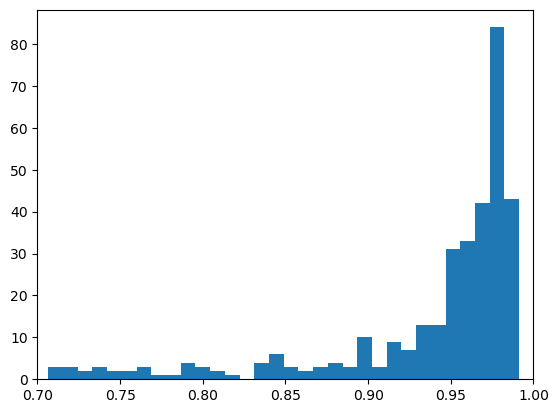

In [23]:
plt.hist(data,bins=80)
plt.xlim(0.7,1)
plt.show()

In [9]:
np.sin(21.4*np.pi)*np.sqrt(19)

-4.14555924412641

In [4]:
np.sin(21.4*np.pi)

-0.9510565162951516

In [8]:
def make_plot(filename2,mark=0):
#######################################
    #
    #               ZCU208
    #
    ########################################
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU208/Abort/'+filename2,allow_pickle=True)
    AC_sum=npz_kw['AC_sum']
    AC_delta=npz_kw['AC_delta']
    BD_sum=npz_kw['BD_sum']
    BD_delta=npz_kw['BD_delta']

    
    timesteps2=np.arange(len(AC_sum))/5120
    timesteps2=timesteps2-timesteps2[-1]

    ##################    


    df = pd.DataFrame({'x':timesteps2,'AC_sum':AC_sum,'AC_delta':AC_delta,'BD_sum':BD_sum,'BD_delta':BD_delta})
    threshold=500
    # 条件に従って 'result' を計算
    df['result_x'] = np.where(df['AC_sum'] > threshold, (df['AC_delta']+df['BD_delta']) / (df['AC_sum']+df['BD_sum']) *(31.8/14.1), 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_x'] = df['result_x']
    offset = df['result_x'].iloc[0:5120].reset_index(drop=True)  # 1行目から5120行目の値
    for i in range(1, len(df) // 5120):
        start = i * 5120
        end = start + 5120-1
        df.loc[start:end, 'result_diff_x'] -= offset.values
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_x'] = np.where(abs(df['result_diff_x']) > 0.7, 0, df['result_diff_x'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_x'] = np.where(df['AC_sum'] <= threshold, np.nan, df['result_diff_x'])
    moving_avg = df['result_diff_x'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_x'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['x_moving_avg'] = moving_avg.reindex(df.index)
    df['x_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_x'] = np.where(df['AC_sum'] <= threshold, 0, df['result_diff_x'])
    df['result_interp_x']=df['result_diff_x']#.interpolate(method='spline',order=1)

    # 条件に従って 'result' を計算
    df['result_y'] = np.where(df['AC_sum'] > threshold, (df['AC_delta']-df['BD_delta']) / (df['AC_sum']+df['BD_sum']) *(32.7/14.1), 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_y'] = df['result_y']
    offset = df['result_y'].iloc[0:5120].reset_index(drop=True)  # 1行目から5120行目の値
    for i in range(1, len(df) // 5120):
        start = i * 5120
        end = start + 5120-1
        df.loc[start:end, 'result_diff_y'] -= offset.values
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_y'] = np.where(abs(df['result_diff_y']) > 0.7, 0, df['result_diff_y'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_y'] = np.where(df['AC_sum'] <= threshold, np.nan, df['result_diff_y'])
    moving_avg = df['result_diff_y'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_y'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['y_moving_avg'] = moving_avg.reindex(df.index)
    df['y_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_y'] = np.where(df['AC_sum'] <= threshold, 0, df['result_diff_y'])
    df['result_interp_y']=df['result_diff_y']#.interpolate(method='spline',order=1)

    # 条件に従って 'result' を計算
    df['result_charge'] = np.where(df['AC_sum'] > threshold,  df['AC_sum']+df['BD_sum'], np.nan)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_charge'] = df['result_charge'] / df['result_charge'].shift(51200)
    
    

    condition = df['AC_sum'] <= 2000
    # 連続する2000以下の行数をカウント
    df['group'] = (condition != condition.shift()).cumsum()
    df['count'] = df.groupby('group')['AC_sum'].transform('size')
    # 2000以下の連続が300行以上になる部分を削除
    index_to_drop = df[(condition) & (df['count'] >= 300)].index[0] if len(df[(condition) & (df['count'] >= 300)]) > 0 else None
    # 該当部分を削除
    if index_to_drop is not None:
        df = df[:index_to_drop]  # 連続部分の開始行以降を削除


    step_size = 40
    turn=len(df)//5120-10
    if turn<10:
        return np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),np.array([np.nan])
    tbtdata_208_x=df['result_interp_x'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_208_x_ma=df['x_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_208_x_std=df['x_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_208_y=df['result_interp_y'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_208_y_ma=df['y_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_208_y_std=df['y_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    charge_208=df['result_diff_charge'].iloc[len(df)-5120*turn:len(df)-0*5120].values

    if mark==1:
        tbtdata_208_x=df['result_interp_AC'].iloc[len(df)-5120*turn:len(df)-0*5120].values
        tbtdata_208_x_ma=df['AC_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
        tbtdata_208_x_std=df['AC_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
        tbtdata_208_y=df['result_interp_BD'].iloc[len(df)-5120*turn:len(df)-0*5120].values
        tbtdata_208_y_ma=df['BD_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
        tbtdata_208_y_std=df['BD_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
        charge_208=df['result_diff_charge'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    turn208=turn

    iii=80
    a=tbtdata_208_x_ma[-80*5120:]
    b=np.full(iii*5120,np.nanstd(tbtdata_208_x))*0.6
    index_208 = next(
            (i for i, (a_val, b_val) in enumerate(zip(a, b))
             if not np.isnan(a_val) and not np.isnan(b_val) and abs(a_val) > b_val),
            80*5120)
    index_208=index_208-80*5120
    print(index_208)
    a=tbtdata_208_y_ma[-80*5120:]
    b=np.full(iii*5120,np.nanstd(tbtdata_208_y))*0.6
    index_208_y = next(
            (i for i, (a_val, b_val) in enumerate(zip(a, b))
             if not np.isnan(a_val) and not np.isnan(b_val) and abs(a_val) > b_val),
            80*5120)
    index_208_y=index_208_y-80*5120
    print(index_208_y)

    if np.nanmax(tbtdata_208_x[:50*5120])-np.nanmin(tbtdata_208_x[:50*5120]) > 0.3:
        return np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),np.array([np.nan])

    if np.nanmax(tbtdata_208_y[:50*5120])-np.nanmin(tbtdata_208_y[:50*5120]) > 0.3:
        return np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),np.array([np.nan])
    

    return tbtdata_208_x_ma[:50*5120], tbtdata_208_y_ma[:50*5120], tbtdata_208_x_ma[-10*5120:], tbtdata_208_y_ma[-10*5120:]


In [9]:
x_ma_208=[]
y_ma_208=[]
x_ma_osc_208=[]
y_ma_osc_208=[]
for i in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU208/Abort/'):
    a,b,c,d=make_plot(i)
    x_ma_208.append(a)
    y_ma_208.append(b)
    x_ma_osc_208.append(c)
    y_ma_osc_208.append(d)

-409436
-41715
-55781
-58969
-53467
-153897
-372501
0
0
-409436
-366448
-58015
-381863
-21140
-392059
-25345
-384375
-226733
-399102
-269562
-335515
-171981
-409380
-308726
-407745
-406091
-110872
-115541
0
0
-398871
-306138
-368814
-14125
-376140
-373222
-385721
-15787
-154424
-402003
0
0
-46085
-22560
-24893
-5830
0
-115459
-407512
0
-387760
-397953
-408017
-311696
0
-275530
-398473
-366708
-324930
-9127
-409435
-17324
-400829
-27367
-409429
0
-409429
-224938
-409436
-409436
0
0
-407816
-24831
-28938
-21546
0
0
-22548
-78571
-409435
0
-246245
0
0
0
-391795
-16591
-7118
-6640
-390319
0
-397881
-409421
-402829
-21428
0
0
-409493
-405140
-71341
-14398
-386646
0
-400071
-9920
-84734
-84972
-408596
-24829
-52122
-52001
-404197
-368937
-409436
-200226
-23577
-200390
-389686
-355292
0
0
-20104
-19647
-372758
-51270
-397669
-11511
-212819
-212842
-409429
-206834
-399126
-47086
-397653
-226188
-409435
-12190
-389605
-158336
-246979
-203513
0
0
-266731
0
0
-402714
-173254
-45166
-378545
-20374

BadZipFile: File is not a zip file

In [112]:
x_ma_208

[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([       nan,        nan,        nan, ...,        nan,        nan,
        0.00804014]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([        nan,         nan,         nan, ...,         nan,
                nan, -0.00113056]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([ 

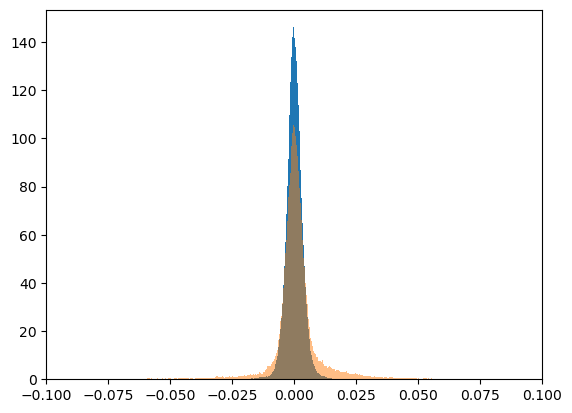

0.003334589032609404


In [10]:
a=np.concatenate(x_ma_208)
a=a[~np.isnan(a)]
#a=a[(a >= -0.03) & (a < 0.03)]

b=np.concatenate(x_ma_osc_208)
b=b[~np.isnan(b)]


plt.hist(a,bins=300,density=True)
plt.hist(b,bins=5000,density=True,alpha=0.5)
plt.xlim(-0.1,0.1)
#plt.yscale('log')
plt.show()
"""
sorted_data = np.sort(np.abs(a))
# 2. 累積確率を計算
cumulative_prob = np.cumsum(sorted_data) / np.sum(sorted_data)
# 3. 累積確率0.99になる値を探す
threshold_index = np.where(cumulative_prob >= 0.95)[0][0]
threshold_value = sorted_data[threshold_index]
print(threshold_value)
"""
print(np.std(a))


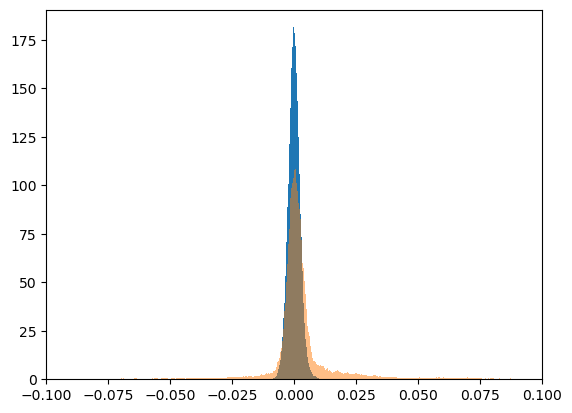

0.002440293567358685


In [11]:
a=np.concatenate(y_ma_208)
a=a[~np.isnan(a)]
#a=a[(a >= -0.03) & (a < 0.03)]

b=np.concatenate(y_ma_osc_208)
b=b[~np.isnan(b)]


plt.hist(a,bins=300,density=True)
plt.hist(b,bins=5000,density=True,alpha=0.5)
plt.xlim(-0.1,0.1)
#plt.yscale('log')
plt.show()
"""
sorted_data = np.sort(np.abs(a))
# 2. 累積確率を計算
cumulative_prob = np.cumsum(sorted_data) / np.sum(sorted_data)
# 3. 累積確率0.99になる値を探す
threshold_index = np.where(cumulative_prob >= 0.95)[0][0]
threshold_value = sorted_data[threshold_index]
print(threshold_value)
"""
print(np.std(a))